In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import time
from scipy.stats import kurtosis
import pickle

from fredholm_datagen_utils import create_data, b1_v, b2_v, b_bar
from fredholm_utils import *

In [12]:
# with open('fredholm_results/lasso.pkl', 'rb') as file:
#     lasso_dict = pickle.load(file)

with open('fredholm_results/lasso_nonglobal_b1.pkl', 'rb') as file:
    lasso_nonglobal_b1_dict = pickle.load(file)

with open('fredholm_results/lasso_nonglobal_b2.pkl', 'rb') as file:
    lasso_nonglobal_b2_dict = pickle.load(file)


with open('fredholm_results/tprior_nonglobal_b1.pkl', 'rb') as file:
    tprior_nonglobal_b1_dict = pickle.load(file)

with open('fredholm_results/tprior_nonglobal_b2.pkl', 'rb') as file:
    tprior_nonglobal_b2_dict = pickle.load(file)


with open('fredholm_results/nonglobal_01_1_-2_b1.pkl', 'rb') as file:
    nonglobal_01_1_neg2_b1_dict = pickle.load(file)

with open('fredholm_results/lasso_nonglobal_b2_smallY.pkl', 'rb') as file:
    lasso_nonglobal_b2_smally_dict = pickle.load(file)

In [13]:
print('b2 extreme values')
print(np.max(lasso_nonglobal_b2_dict['b_mat']), np.min(lasso_nonglobal_b2_dict['b_mat']))
print(np.max(lasso_nonglobal_b2_smally_dict['b_mat']), np.min(lasso_nonglobal_b2_smally_dict['b_mat']))
print(np.max(tprior_nonglobal_b2_dict['b_mat']), np.min(tprior_nonglobal_b2_dict['b_mat']))

print(np.max(lasso_nonglobal_b2_dict['beta_record'][-1]), np.min(lasso_nonglobal_b2_dict['beta_record'][-1]))
print(np.max(lasso_nonglobal_b2_smally_dict['beta_record'][-1]), np.min(lasso_nonglobal_b2_smally_dict['beta_record'][-1]))
print(np.max(tprior_nonglobal_b2_dict['beta_record'][-1]), np.min(tprior_nonglobal_b2_dict['beta_record'][-1]))
print()
print('b1 extreme values')
print(np.max(lasso_nonglobal_b1_dict['b_mat']), np.min(lasso_nonglobal_b1_dict['b_mat']))
print(np.max(tprior_nonglobal_b1_dict['b_mat']), np.min(tprior_nonglobal_b1_dict['b_mat']))

print(np.max(lasso_nonglobal_b1_dict['beta_record'][-1]), np.min(lasso_nonglobal_b1_dict['beta_record'][-1]))
print(np.max(tprior_nonglobal_b1_dict['beta_record'][-1]), np.min(tprior_nonglobal_b1_dict['beta_record'][-1]))

b2 extreme values
60069870.0 59410370.0
23896.316 13248.298
60069870.0 59410370.0
2.4466978372138e+31 -2.446697837213935e+31
2.4514950780685645 -3.2393617861043973
2.4466978372138e+31 -2.446697837213935e+31

b1 extreme values
925.2319 -726.1079
925.2319 -726.1079
3.405282866275308 -2.0335831937647333
4.4873752702148 -7.551314551337309


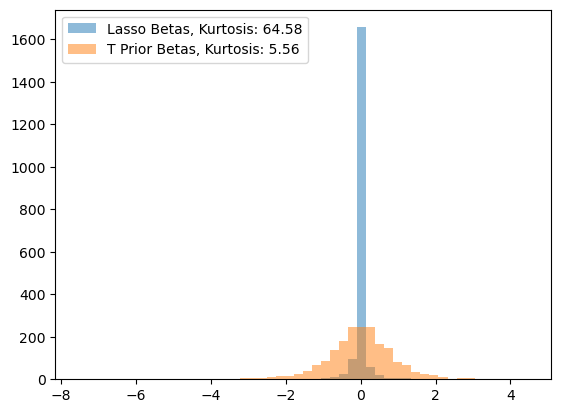

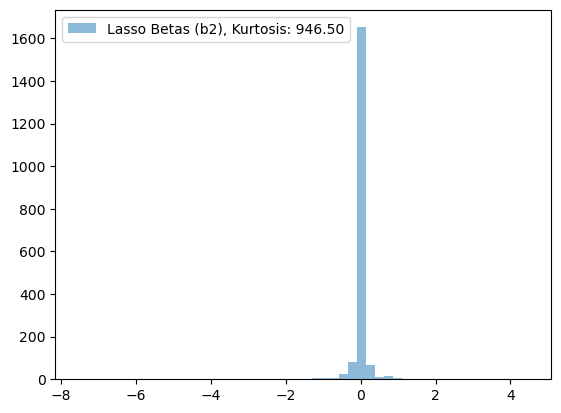

In [14]:
lasso_nonglobal_betas = lasso_nonglobal_b1_dict['beta_record'][-1]
tprior_nonglobal_betas = tprior_nonglobal_b1_dict['beta_record'][-1]

lasso_nonglobal_b2_smally_betas = lasso_nonglobal_b2_smally_dict['beta_record'][-1]

lasso_nonglobal_b2_betas = lasso_nonglobal_b2_dict['beta_record'][-1]
tprior_nonglobal_b2_betas = tprior_nonglobal_b2_dict['beta_record'][-1]

kurtosis_final_lasso_nonglobal = kurtosis(lasso_nonglobal_betas)
kurtosis_final_tprior_nonglobal = kurtosis(tprior_nonglobal_betas)

kurtosis_final_lasso_nonglobal_b2 = kurtosis(lasso_nonglobal_b2_betas)
kurtosis_final_tprior_nonglobal_b2 = kurtosis(tprior_nonglobal_b2_betas)


bins = np.histogram(np.hstack((lasso_nonglobal_betas, tprior_nonglobal_betas)), bins=50)[1]

plt.hist(lasso_nonglobal_betas, bins=bins, alpha=0.5, label=f'Lasso Betas, Kurtosis: {kurtosis_final_lasso_nonglobal:.2f}')
plt.hist(tprior_nonglobal_betas, bins=bins, alpha=0.5, label=f'T Prior Betas, Kurtosis: {kurtosis_final_tprior_nonglobal:.2f}')
# plt.hist(lasso_b2_betas, bins=bins, alpha=0.5, label=f'Lasso Betas (B2), Kurtosis: {kurtosis_final_lasso_b2:.2f}')
# plt.hist(tprior_betas, bins=bins, alpha=0.5, label=f'T Prior Betas (0,2,-1), Kurtosis: {kurtosis_final_tprior:.2f}')
plt.legend()
plt.show()

# bins = np.histogram(np.hstack((tprior_nonglobal_b2_betas, lasso_nonglobal_b2_betas)), bins=50)[1]

# plt.hist(lasso_betas, bins=bins, alpha=0.5, label=f'Lasso Betas, Kurtosis: {kurtosis_final_lasso:.2f}')
# plt.hist(lasso_nonglobal_betas, bins=bins, alpha=0.5, label=f'Lasso Betas (No global prior), Kurtosis: {kurtosis_final_lasso_nonglobal:.2f}')

# plt.hist(lasso_nonglobal_b2_betas, bins=bins, alpha=0.5, label=f'Lasso Betas (b2), Kurtosis: {kurtosis_final_lasso_nonglobal_b2:.2f}')
# plt.hist(tprior_nonglobal_b2_betas, bins=bins, alpha=0.5, label=f'T Prior Betas (b2), Kurtosis: {kurtosis_final_tprior_nonglobal_b2:.2f}')
plt.hist(lasso_nonglobal_b2_smally_betas, bins=bins, alpha=0.5, label=f'Lasso Betas (b2), Kurtosis: {kurtosis_final_lasso_nonglobal_b2:.2f}')
plt.legend()
plt.show()

Try using the gamma*y

Try using xy-x^3y^2 using y from (-20 to 20)

try other methods of matrix inversion (cholesky decomp maybe)

9/(x+y^2)-5

Instead of truncated normal, look at a beta distributions since they are ranging in [0,1]
- Beta(3, 2) for example (with mean 3/5)

Add a saving feature of lambda mat record

try a larger diffusion (1.5 instead of 1)

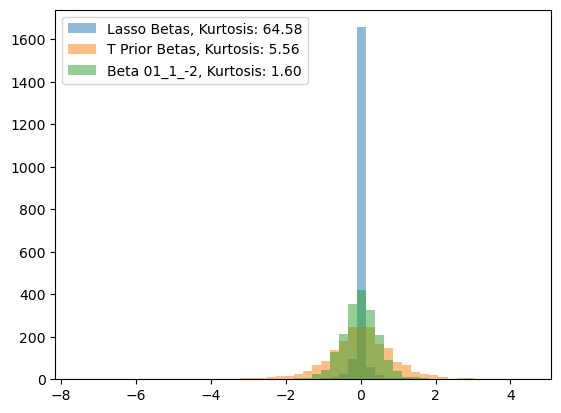

In [8]:
beta_nonglobal_01_1_neg2_b1 = nonglobal_01_1_neg2_b1_dict['beta_record'][-1]  # New beta values

# Calculate kurtosis for all beta values
kurtosis_final_lasso_nonglobal = kurtosis(lasso_nonglobal_betas)
kurtosis_final_tprior_nonglobal = kurtosis(tprior_nonglobal_betas)
kurtosis_nonglobal_01_1_neg2_b1 = kurtosis(beta_nonglobal_01_1_neg2_b1)  # New kurtosis

# Generate common bins based on all beta records
bins = np.histogram(np.hstack((lasso_nonglobal_betas, tprior_nonglobal_betas, beta_nonglobal_01_1_neg2_b1)), bins=50)[1]

# Plot histograms
plt.hist(lasso_nonglobal_betas, bins=bins, alpha=0.5, label=f'Lasso Betas, Kurtosis: {kurtosis_final_lasso_nonglobal:.2f}')
plt.hist(tprior_nonglobal_betas, bins=bins, alpha=0.5, label=f'T Prior Betas, Kurtosis: {kurtosis_final_tprior_nonglobal:.2f}')
plt.hist(beta_nonglobal_01_1_neg2_b1, bins=bins, alpha=0.5, label=f'Beta 01_1_-2, Kurtosis: {kurtosis_nonglobal_01_1_neg2_b1:.2f}')  # New histogram

# Display the plot with legend
plt.legend()
plt.show()

In [5]:
lasso_nonglobal_b1_dict['meta_data']

{'scale': 3.1622776601683795,
 'loc': 1,
 'a_trunc': -100,
 'b_trunc': 100,
 'diffusion': 1,
 't_delta': 0.05,
 't_end': 100.0,
 'start_val': 0,
 'gibbs_iters': 25,
 'chunk_size': 150,
 'integral_n': 5000,
 'y_domain': (-50.0, 50.0),
 'results_filepath': 'fredholm/fredholm_results/lasso_nonglobal_b1.pkl',
 'local_gig_a': 2.0,
 'local_gig_b': 0.0,
 'local_gig_p': 1.0,
 'global_gig_a': 0.0,
 'global_gig_b': 0.0,
 'global_gig_p': 0.0,
 'kernel_name': 'gauss',
 'timer': True}

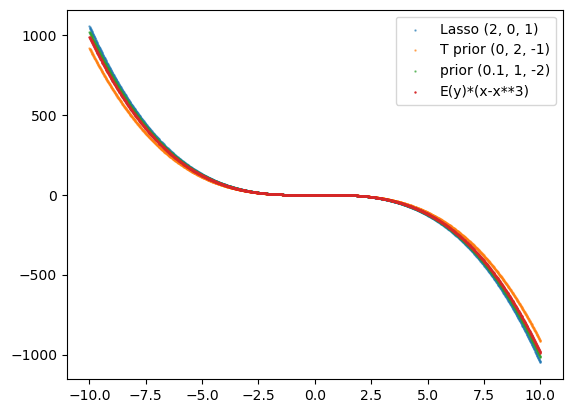

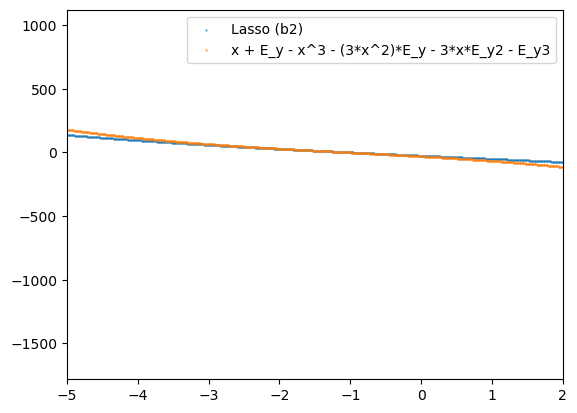

In [20]:
init_data = lasso_nonglobal_b1_dict['init_data']
init_data2 = lasso_nonglobal_b2_dict['init_data']
range_linspace= [-10,10]

# b1_mat = estimated_b_function_matrix(
#     range_linspace=range_linspace,
#     init_data=init_data,
#     kernel = gauss_kernel,
#     known_b=b1_v,
#     y_domain=[-50,50],
#     int_N = 5000
# )
# 
# b2_mat = estimated_b_function_matrix(
#     range_linspace=range_linspace,
#     init_data=init_data2,
#     kernel = gauss_kernel,
#     known_b=b2_v,
#     y_domain=[-10,10],
#     int_N = 5000
# )

x_vals = np.linspace(range_linspace[0], range_linspace[1], len(init_data)-1)
E_y, E_y2, E_y3 = 1, 11, 31
b_bar2_manual = x_vals + E_y - x_vals**3 - (3*x_vals**2)*E_y - 3*x_vals*E_y2 - E_y3

# plt.scatter(x_vals, estimated_b_function_calc(b_mat, np.random.normal(0,0.1, len(first_betas))), alpha = 0.6, s=0.5, label='absolute random')
# plt.scatter(x_vals, estimated_b_function_mat_calc(b1_mat, lasso_betas), alpha = 0.6, s=0.5, label='Lasso')
plt.scatter(x_vals, estimated_b_function_mat_calc(b1_mat, lasso_nonglobal_betas), alpha = 0.6, s=0.5, label='Lasso (2, 0, 1)')
plt.scatter(x_vals, estimated_b_function_mat_calc(b1_mat, tprior_nonglobal_betas), alpha = 0.6, s=0.5, label='T prior (0, 2, -1)')
plt.scatter(x_vals, estimated_b_function_mat_calc(b1_mat, beta_nonglobal_01_1_neg2_b1), alpha = 0.6, s=0.5, label='prior (0.1, 1, -2)')
plt.scatter(x_vals, (x_vals-x_vals**3), s=0.5, label='E(y)*(x-x**3)')
plt.legend()
plt.show()

plt.scatter(x_vals, estimated_b_function_mat_calc(b2_mat, lasso_nonglobal_b2_smally_betas), alpha = 0.6, s=0.5, label='Lasso (b2)')
# plt.scatter(x_vals, estimated_b_function_mat_calc(b2_mat, tprior_nonglobal_b2_betas), alpha = 0.6, s=0.5, label='T Prior (b2)')
plt.scatter(x_vals, b_bar2_manual, label='x + E_y - x^3 - (3*x^2)*E_y - 3*x*E_y2 - E_y3', s=0.8, alpha=0.5)
plt.xlim(-5, 2)
# plt.scatter(x_vals, (x_vals-x_vals**3), s=0.5, label='(x-x**3)')
plt.legend()
plt.show()

(array([ 15.,  50., 187., 340., 499., 409., 241., 134.,  21.,   4.]),
 array([-1.83899185, -1.66191662, -1.48484139, -1.30776616, -1.13069093,
        -0.9536157 , -0.77654048, -0.59946525, -0.42239002, -0.24531479,
        -0.06823956]),
 <BarContainer object of 10 artists>)

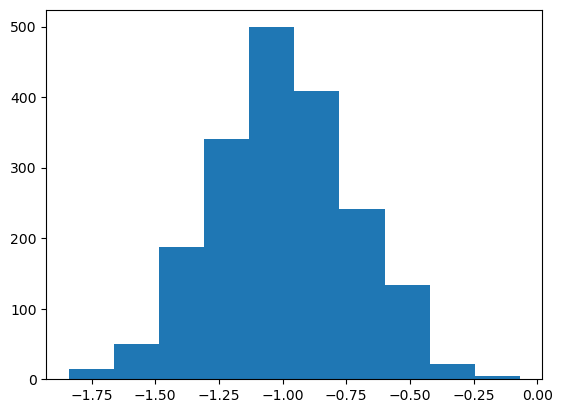

In [17]:
plt.hist(init_data2)

# Stationary Distributions

In [23]:
from scipy.stats import uniform

def create_data(diffusion, b_func, t_delta, t_end, start_val, verbose=False, **kwargs):
    """
    Simulates and returns a sequence of data points representing the evolution of a system over time, based on a specified deterministic function and a stochastic diffusion component.
    The simulation omits the initial 5% of data points to focus on the stabilized behavior of the system.

    Parameters:
    - diffusion (float): Intensity of the stochastic fluctuation component.
    - b_func (callable): Deterministic function that defines the system's evolution, accepting the current system value and optional keyword arguments.
    - t_delta (float): Time increment for each simulation step.
    - t_end (float): Total duration of the simulation.
    - start_val (float): Initial value of the system.
    - **kwargs: Additional keyword arguments passed to the deterministic function.

    Returns:
    - list of float: A list of simulated system values after the initial transient phase.
    """
    t = 0
    val = start_val
    data = []

    def create_next(val):
        return val + b_func(val, **kwargs) * t_delta + diffusion * np.random.normal(0, np.sqrt(t_delta))

    while t < t_end - t_delta:
        data.append(val)
        val = create_next(val)
        t += t_delta
        if verbose: # and (t-int(t) == 0 or t-int(t)==0.5):
            print(f'Generated data up to t = {t}/{t_end}')

    return data[len(data) // 20:]

Generated data up to t = 0.05/20
Generated data up to t = 0.1/20
Generated data up to t = 0.15000000000000002/20
Generated data up to t = 0.2/20
Generated data up to t = 0.25/20
Generated data up to t = 0.3/20
Generated data up to t = 0.35/20
Generated data up to t = 0.39999999999999997/20
Generated data up to t = 0.44999999999999996/20
Generated data up to t = 0.49999999999999994/20
Generated data up to t = 0.5499999999999999/20
Generated data up to t = 0.6/20
Generated data up to t = 0.65/20
Generated data up to t = 0.7000000000000001/20
Generated data up to t = 0.7500000000000001/20
Generated data up to t = 0.8000000000000002/20
Generated data up to t = 0.8500000000000002/20
Generated data up to t = 0.9000000000000002/20
Generated data up to t = 0.9500000000000003/20
Generated data up to t = 1.0000000000000002/20
Generated data up to t = 1.0500000000000003/20
Generated data up to t = 1.1000000000000003/20
Generated data up to t = 1.1500000000000004/20
Generated data up to t = 1.2000

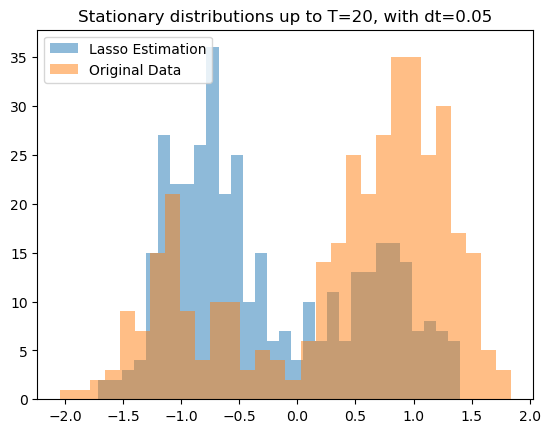

In [24]:
diffusion = 1

t_delta = 0.05
t_end = 20
start_val = 0

integral_N = 5000

np.random.seed(0)
lasso_est_stationary = create_data(t_delta=t_delta, t_end=t_end, start_val=start_val, diffusion=diffusion, verbose=True, kernel=gauss_kernel, b_func=b1_est_func_vect_calc, betas=lasso_betas, known_b=b1_v, y_rvs=uniform(-100,100), int_N=5000, init_data=init_data)

# np.random.seed(0)
# tprior_est_stationary = create_data(t_delta=t_delta, t_end=t_end, start_val=start_val, diffusion=diffusion, verbose=True, kernel=gauss_kernel, b_func=b1_est_func_vect_calc, betas=tprior_betas, known_b=b1_v, y_rvs=uniform(-100,100), int_N=5000, init_data=init_data)

plt.hist(lasso_est_stationary, bins=30, alpha=0.5, label='Lasso Estimation')
# plt.hist(tprior_est_stationary, bins=30, alpha=0.5, label='T-prior Estimation')
plt.hist(init_data[:len(lasso_est_stationary)], bins=30, alpha=0.5, label='Original Data')
plt.legend()
plt.title('Stationary distributions up to T=20, with dt=0.05')
plt.show()

Generated data up to t = 0.05/20
Generated data up to t = 0.1/20
Generated data up to t = 0.15000000000000002/20
Generated data up to t = 0.2/20


C:\Users\harry\DataspellProjects\BayesSDEs\fredholm\fredholm_utils.py:79: RuntimeWarning: overflow encountered in cast
  b_y = known_b(val, y_z[:, 0]).astype(np.float32) # shape (N,)
C:\Users\harry\DataspellProjects\BayesSDEs\fredholm\fredholm_utils.py:86: RuntimeWarning: invalid value encountered in multiply
  b = b_y * b_z * kern_vals # try doing this with built-in broadcasting in numpy


Generated data up to t = 0.25/20
Generated data up to t = 0.3/20
Generated data up to t = 0.35/20
Generated data up to t = 0.39999999999999997/20
Generated data up to t = 0.44999999999999996/20
Generated data up to t = 0.49999999999999994/20
Generated data up to t = 0.5499999999999999/20
Generated data up to t = 0.6/20
Generated data up to t = 0.65/20
Generated data up to t = 0.7000000000000001/20
Generated data up to t = 0.7500000000000001/20
Generated data up to t = 0.8000000000000002/20
Generated data up to t = 0.8500000000000002/20
Generated data up to t = 0.9000000000000002/20
Generated data up to t = 0.9500000000000003/20
Generated data up to t = 1.0000000000000002/20
Generated data up to t = 1.0500000000000003/20
Generated data up to t = 1.1000000000000003/20
Generated data up to t = 1.1500000000000004/20
Generated data up to t = 1.2000000000000004/20
Generated data up to t = 1.2500000000000004/20
Generated data up to t = 1.3000000000000005/20
Generated data up to t = 1.35000000

C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\ProgramData\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

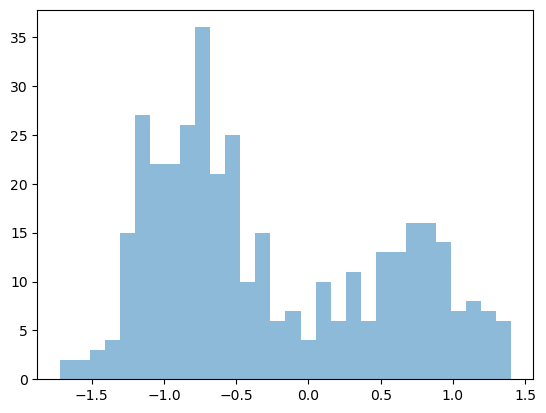

In [25]:
np.random.seed(0)
tprior_est_stationary = create_data(t_delta=t_delta, t_end=t_end, start_val=start_val, diffusion=diffusion, verbose=True, kernel=gauss_kernel, b_func=b1_est_func_vect_calc, betas=tprior_betas, known_b=b1_v, y_rvs=uniform(-100,100), int_N=5000, init_data=init_data)

plt.hist(lasso_est_stationary, bins=30, alpha=0.5, label='Lasso Estimation')
plt.hist(tprior_est_stationary, bins=30, alpha=0.5, label='T-prior Estimation')
plt.hist(init_data[:len(lasso_est_stationary)], bins=30, alpha=0.5, label='Original Data')
plt.legend()
plt.title('Stationary distributions up to T=20, with dt=0.05')
plt.show()

In [ ]:
np.random.seed(0)
lasso_b2_est_stationary = create_data(t_delta=t_delta, t_end=t_end, start_val=start_val, diffusion=diffusion, verbose=True, kernel=gauss_kernel, b_func=b1_est_func_vect_calc, betas=lasso_b2_betas, known_b=b2_v, y_rvs=uniform(-100,100), int_N=5000, init_data=init_data)

# np.random.seed(0)
# tprior_est_stationary = create_data(t_delta=t_delta, t_end=t_end, start_val=start_val, diffusion=diffusion, verbose=True, kernel=gauss_kernel, b_func=b1_est_func_vect_calc, betas=tprior_betas, known_b=b1_v, y_rvs=uniform(-100,100), int_N=5000, init_data=init_data)

plt.hist(lasso_b2_est_stationary, bins=30, alpha=0.5, label='Lasso b2 Estimation')
# plt.hist(tprior_est_stationary, bins=30, alpha=0.5, label='T-prior Estimation')
plt.hist(init_data[:len(lasso_b2_est_stationary)], bins=30, alpha=0.5, label='Original Data')
plt.legend()
plt.title('Stationary distributions up to T=20, with dt=0.05')
plt.show()